# Linear-regression as changepoint detection
## A motivating example
(Faster version)
We consider a univariate regression problem

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

In [ ]:
import jax
import distrax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm import tqdm
from functools import partial
from rebayes_mini.callbacks import get_predicted_mean
from rebayes_mini.methods.gauss_filter import GaussianFilter
from rebayes_mini.methods.adaptive import LinearModelFMBOCD
from rebayes_mini.methods.adaptive import RobustLinearModelFMBOCD

In [3]:
sns.set_palette("colorblind")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

In [6]:
@partial(jax.vmap, in_axes=(None, 0))
def get_segment_init(segment, n):
    return jnp.where(segment == n, size=len(segment))[0][0] 

In [7]:
def get_log_posterior_tril(log_posterior, n_samples):
    log_posterior_tri = np.zeros((n_samples, n_samples))
    log_posterior_tri[np.tril_indices(n_samples)] = log_posterior
    log_posterior_tri[np.triu_indices(n_samples, k=1)] = np.nan
    return log_posterior_tri


def compute_top_k_runlenghts(log_posterior_tri, n_samples, K):
    runlengths = np.zeros((n_samples, K))
    probs_K = np.zeros((n_samples, K))

    for i, ix in enumerate(range(n_samples)):
        vals = np.argsort(-log_posterior_tri[ix, :ix+1])[:K]
        iput = np.minimum(i, K) + 1
        probs_sub = np.exp(log_posterior_tri[ix])[vals]

        runlengths[i, :iput] = vals
        probs_K[i, :iput] = probs_sub / probs_sub.sum()
    return runlengths, probs_K

In [8]:
p_change = 0.005
p_change = 0.01

def step(params, key):
    key_x, key_y, key_change, key_params = jax.random.split(key, 4)

    change = jax.random.uniform(key_change) < p_change

    key_theta0, key_theta1, key_theta2 = jax.random.split(key_params, 3)
    params_change = jax.random.uniform(key_params, (3,), minval=-3, maxval=3)
    
    params = params * (1 - change) + params_change * change

    x = jax.random.uniform(key_x, minval=-2, maxval=2)
    x = jnp.c_[1, x, x ** 2]
    
    yclean = x @ params
    y = yclean + jax.random.t(key_y, df=2.01)
    # y = yclean + jax.random.normal(key_y)

    out = {
        "params": params,
        "y": y,
        "x": x,
        "yclean": yclean,
        "change": change,
    }

    return params, out

In [9]:
key = jax.random.PRNGKey(27)

In [10]:
n_samples = 300
keys = jax.random.split(key, n_samples)
theta_init = jnp.array([1.0, 1.0, 1.0])

_, hist = jax.lax.scan(step, theta_init, keys)
hist = jax.tree.map(np.array, hist)

In [11]:
segment = hist["change"].cumsum()

n_segments = len(np.unique(segment))
n_segments

6

In [12]:
n_segments = len(np.unique(segment))
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)

In [13]:
cmap = {
    # s: plt.cm.tab10(s)
    s: sns.color_palette()[s]
    for s in range(n_segments)
}

colors = [cmap[s] for s in segment]

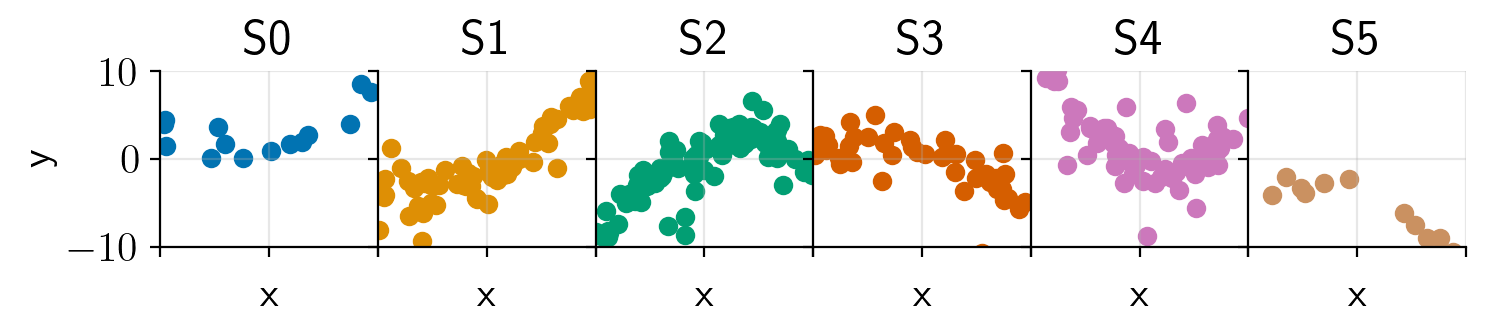

In [14]:
fig, axs = plt.subplots(1, n_segments, sharey=True, figsize=(6.4 * 1.2, 4.8 * 0.4))
axs = axs.ravel()
    
for n in np.arange(n_segments):
    axs[n].set_title(f"S{n}")
    color = cmap[n]
    ixs = jnp.where(segment == n)[0]
    xsub = hist["x"][ixs, :, 1]
    ysub = hist["y"][ixs]
    axs[n].scatter(xsub, ysub, color=color)
    axs[n].grid(alpha=0.3)
    axs[n].set_xlabel("x")
    axs[n].set_xlim(-2, 2)
    axs[n].set_ylim(top=10, bottom=-10)
    axs[n].set_xticks([-2, 0, 2], labels=["", "", ""])

axs[0].set_ylabel("y")
plt.tight_layout()
plt.subplots_adjust(wspace=0.0)
plt.savefig("../figures/segments-tdist-lr.png", dpi=300, bbox_inches="tight")

In [15]:
X = hist["x"]
y = hist["y"]

## Problem formulation

Observation model
$$
    p(y_t \vert \boldsymbol\theta_t, {\bf x}_t) = {\cal N}(y_t \vert {\bf x}_t^\intercal\boldsymbol\theta_t, \beta)
$$

with known observation precision $\tau$ and prior
$$
    p(\boldsymbol\theta_t) = {\cal N}\left(\boldsymbol\theta_t \vert \boldsymbol 0, \alpha^{-1}{\bf I}\right)
$$


### The components

**The predictive probability**

$$
\begin{aligned}
    p(\boldsymbol y_t \vert \boldsymbol\mu, \boldsymbol\Sigma, {\bf x}_t)
    &= \int p(\boldsymbol y_t, \boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma, {\bf x}_t) d\boldsymbol\theta\\
    &= \int p(\boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma)p(\boldsymbol y_t \vert \boldsymbol\theta, {\bf x}_t)d\boldsymbol\theta\\
    &= \int {\cal N}(\boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma)
    {\cal N}(\boldsymbol y_t \vert \boldsymbol\theta^\intercal {\bf x}_t, \beta^{-1})d\boldsymbol\theta\\
    &=
    {\cal N}(\boldsymbol y_t \vert \boldsymbol\mu^\intercal {\bf x}_t, \beta^{-1} + {\bf x}_t^\intercal\boldsymbol\Sigma{\bf x}_t)
\end{aligned}
$$

**Growth / change — runlength probabilities**

In [16]:
beta = 1.0
alpha = 1.0
d = 3
wprior = jnp.zeros(d)
wcov_prior = jnp.eye(d) * 10

In [17]:
y = jnp.squeeze(y)
X = jnp.squeeze(X)

In [18]:
rsteps = np.arange(n_samples)

In [19]:
yclean = np.array(hist["yclean"]).squeeze()

## BOCD

In [20]:
bocd = LinearModelFMBOCD(p_change, beta)
bel_init = bocd.init_bel(wprior, 10.0, n_samples)
bocd_out = bocd.scan(y, X, bel_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:24<00:00,  3.55it/s]


In [21]:
bocd_out = jax.tree.map(np.array, bocd_out)
log_cond_ravel = bocd_out["log_runlength_posterior"]
marginal = bocd_out["marginal"]
pr_change_ravel = np.exp(log_cond_ravel)

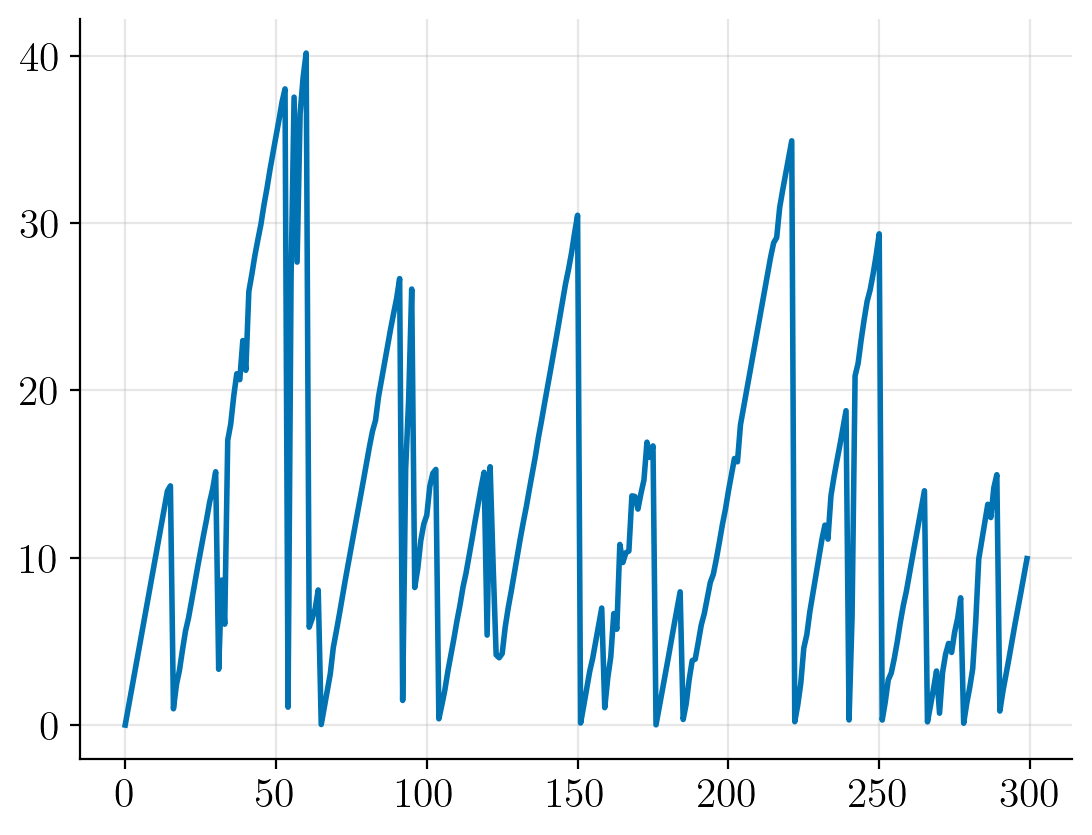

In [22]:
K = 12
log_cond_show = get_log_posterior_tril(log_cond_ravel, n_samples)
runlengths, probs_K = compute_top_k_runlenghts(log_cond_show, n_samples, K)

plt.plot(rsteps, (runlengths * probs_K).sum(axis=1), linewidth=2, label="BOCD")
plt.grid(alpha=0.3)

## WoLF-BOCD

In [23]:
c = 6
wlbocd = RobustLinearModelFMBOCD(p_change, beta, c)
bel_init = wlbocd.init_bel(wprior, 1.0, n_samples)
wlbocd_out = wlbocd.scan(y, X, bel_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:23<00:00, 12.97it/s]


In [24]:
wlbocd_out = jax.tree.map(np.array, wlbocd_out)
wl_log_cond_ravel = wlbocd_out["log_runlength_posterior"]
wl_marginal = wlbocd_out["marginal"]
wl_pr_change_ravel = np.exp(wl_log_cond_ravel)

In [25]:
jax.tree.map(np.shape, wlbocd_out)

{'bel': GaussState(mean=(45150, 3), cov=(45150, 3, 3)),
 'log_joint': (45150,),
 'log_runlength_posterior': (45150,),
 'marginal': (300,)}

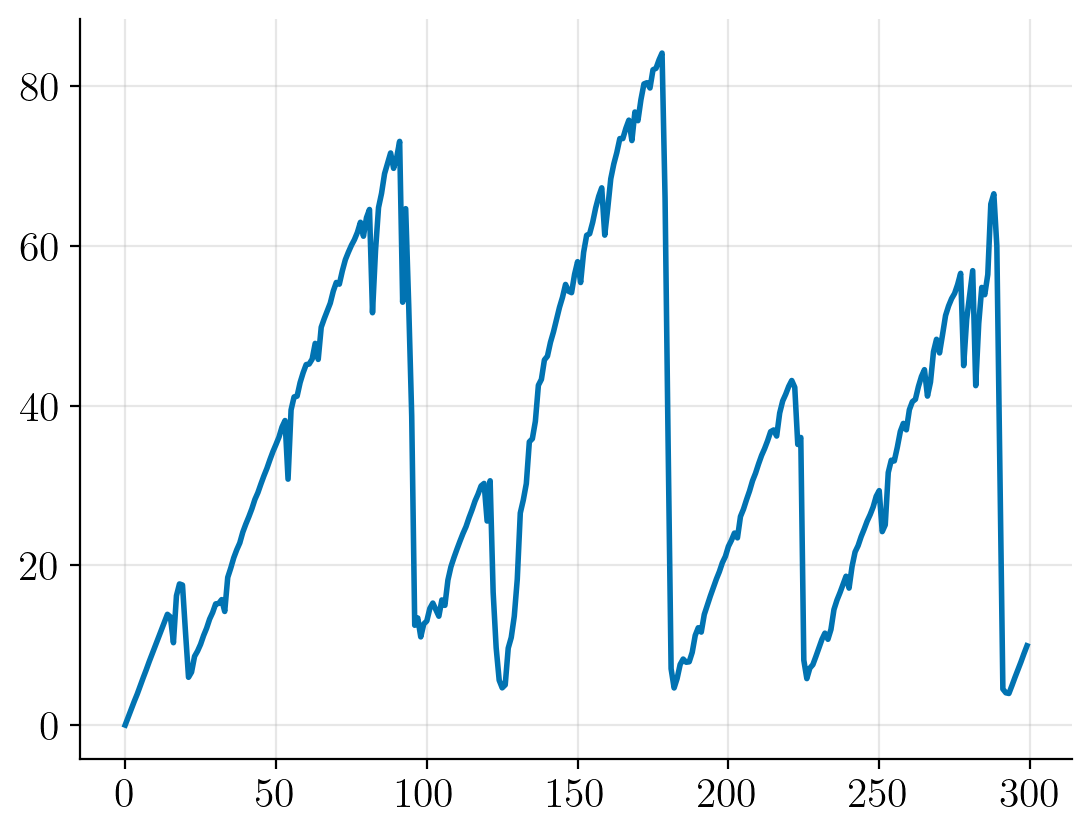

In [26]:
K = 20
wl_log_cond_show = get_log_posterior_tril(wl_log_cond_ravel, n_samples)
wl_runlengths, wl_probs_K = compute_top_k_runlenghts(wl_log_cond_show, n_samples, K)

plt.plot(rsteps, (wl_runlengths * wl_probs_K).sum(axis=1), linewidth=2, label="BOCD")
plt.grid(alpha=0.3)

# Heatmaps

## BOCD

In [28]:
log_cond_show = get_log_posterior_tril(log_cond_ravel, n_samples)
pr_change = np.exp(log_cond_show)
runlength_map = np.nanargmax(log_cond_show[1:], axis=1)
runlength_map = np.insert(runlength_map, 0, 0)

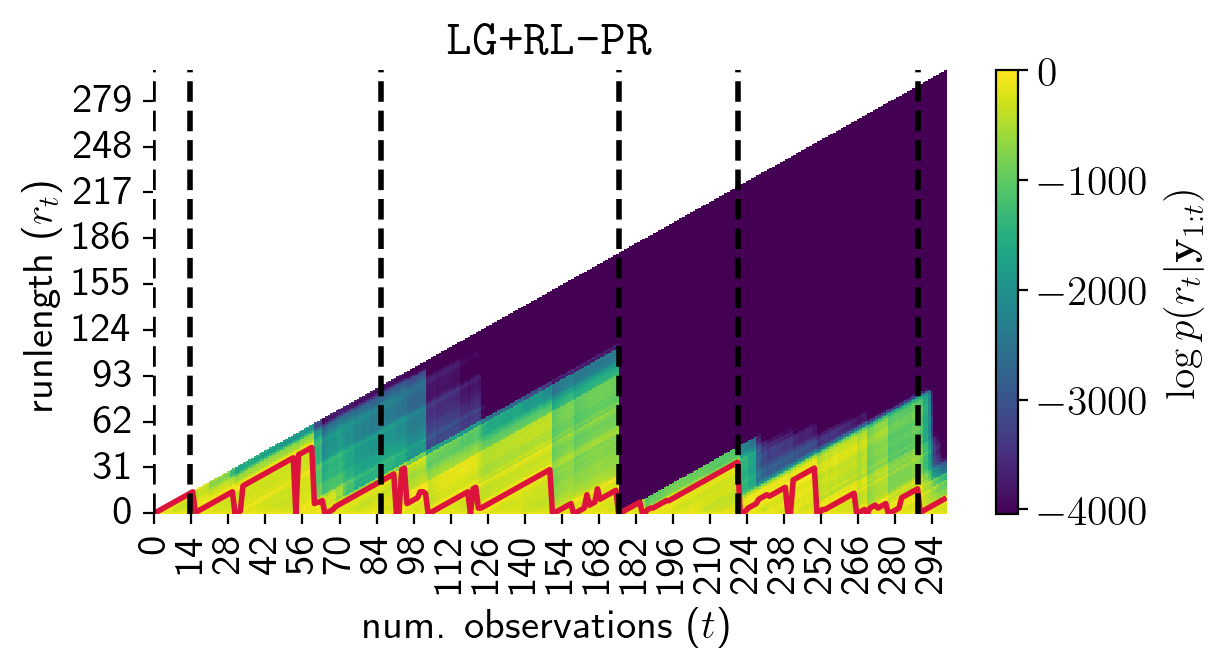

In [30]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))
sns.heatmap(log_cond_show.T, cbar=False, vmin=-200, cmap="viridis")
plt.gca().invert_yaxis()

plt.plot(runlength_map, c="crimson", linewidth=2)
# plt.plot(rsteps, runlengths.mean(axis=1), c="black")

vmax = np.nanmax(log_cond_show)
vmin = np.nanmin(log_cond_show)

for s in segments_init:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)
plt.xlabel("num. observations ($t$)")
plt.ylabel(r"runlength ($r_t$)")
plt.title(r"\texttt{LG+RL-PR}")

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis),
             ax=ax, orientation='vertical', label=r"$\log p(r_{t} \vert {\bf y}_{1:t})$")


plt.savefig("../figures/rlpr-tnoise-rl-log-posterior.png", dpi=300, bbox_inches="tight")

## WoLF+RL-PR

In [31]:
log_cond_show = get_log_posterior_tril(wl_log_cond_ravel, n_samples)
pr_change = np.exp(log_cond_show)
runlength_map = np.nanargmax(log_cond_show[1:], axis=1)
runlength_map = np.insert(runlength_map, 0, 0)

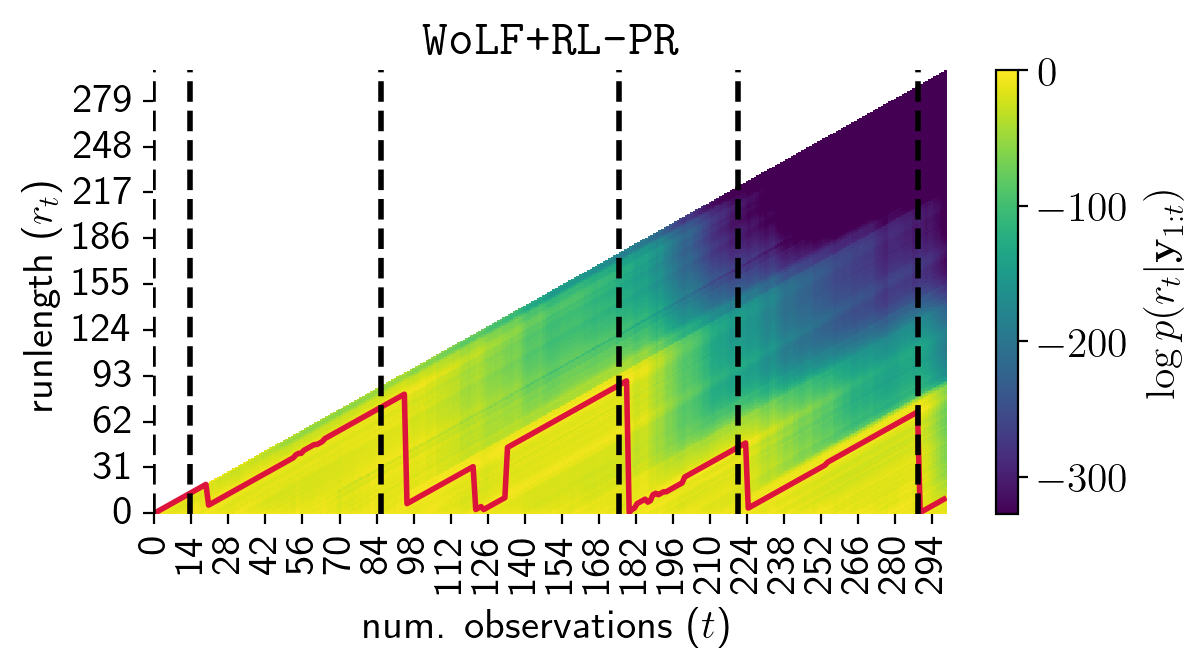

In [32]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))
sns.heatmap(log_cond_show.T, cbar=False, vmin=-200, cmap="viridis")
plt.gca().invert_yaxis()

plt.plot(runlength_map, c="crimson", linewidth=2)
# plt.plot(rsteps, runlengths.mean(axis=1), c="black")

vmax = np.nanmax(log_cond_show)
vmin = np.nanmin(log_cond_show)

for s in segments_init:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)
plt.xlabel("num. observations ($t$)")
plt.ylabel(r"runlength ($r_t$)")
plt.title(r"\texttt{WoLF+RL-PR}")

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis),
             ax=ax, orientation='vertical', label=r"$\log p(r_{t} \vert {\bf y}_{1:t})$")

plt.savefig("../figures/rlpr-wolf-tnoise-rl-log-posterior.png", dpi=300, bbox_inches="tight")

## Animation

In [34]:
xtest = np.linspace(-2, 2, 200)
@jax.vmap
def phi(x): return jnp.array([1, x, x ** 2])
Phi_test = phi(xtest)

In [35]:
Xcpu = np.array(X.squeeze())
ycpu = np.array(y.squeeze())
Phi_test = np.array(Phi_test)

In [36]:
cmap = {
    # s: sns.color_palette()[s]
    s: sns.color_palette("viridis", n_segments)[s]
    for s in range(n_segments)
}

colors = [cmap[s] for s in np.array(segment)]

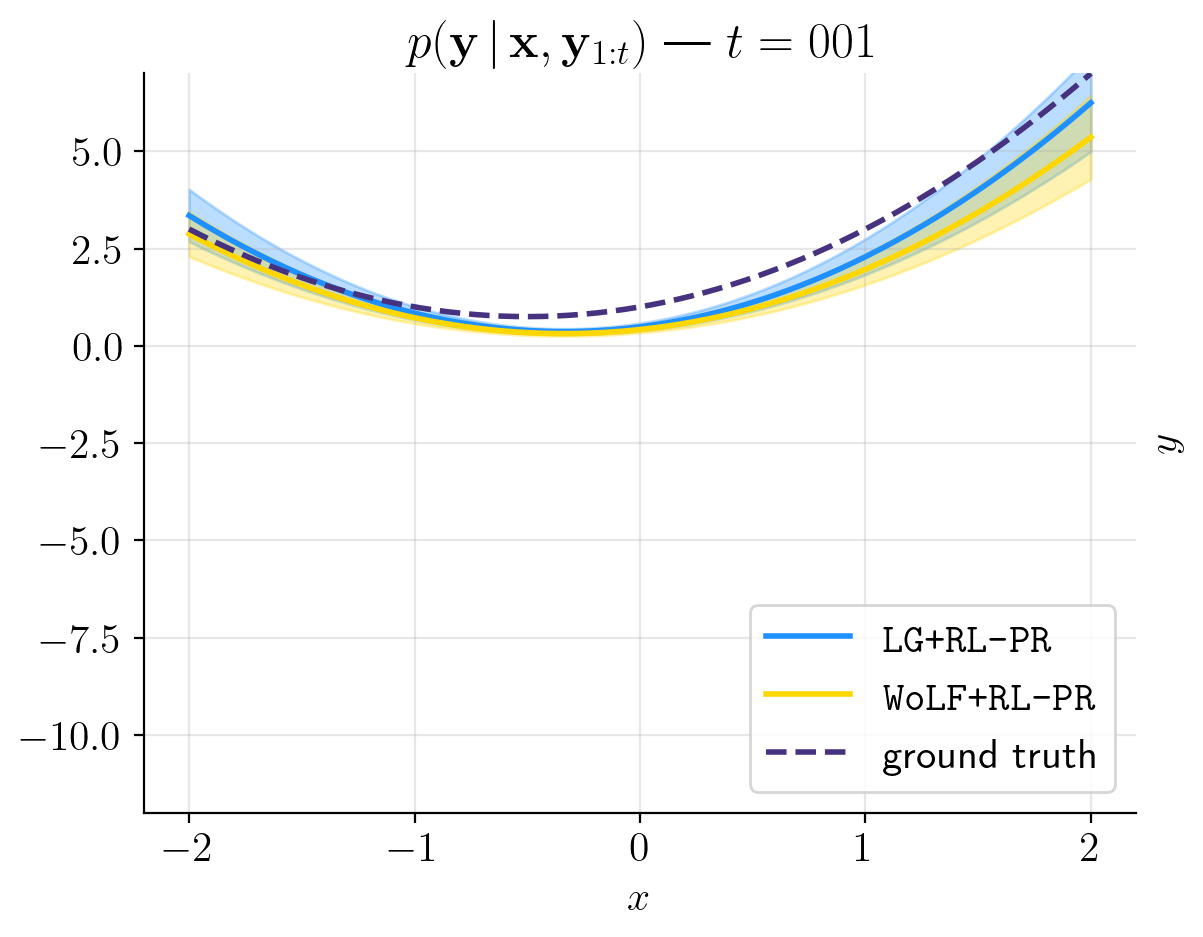

In [37]:
fig, ax = plt.subplots()

def get_ix(t, ell):
    # Number of steps to get to first observation at time t
    ix_step = t * (t + 1) // 2
    # Increase runlength
    ix = ix_step + ell
    return ix

xeval = Phi_test[:, 1]
def animate(t):
    ax.cla()
    print(t, end="\r")
    
    ix_init = get_ix(t, 0)
    ix_end = get_ix(t, t+1)

    params_true = hist["params"][t]
    ytrue = np.einsum("nm,m->n", Phi_test, params_true)

    yhat = np.einsum("sm,km -> sk", Phi_test, bocd_out["bel"].mean[ix_init:ix_end])
    yhat_mean = np.einsum("sk,k-> s", yhat, pr_change_ravel[ix_init:ix_end])
    yhat_std = np.sqrt(
        jnp.einsum("sk,k-> s", yhat ** 2, pr_change_ravel[ix_init:ix_end]) - yhat_mean ** 2
    )

    awyhat = np.einsum("sm,km -> sk", Phi_test, wlbocd_out["bel"].mean[ix_init:ix_end])
    awyhat_mean = np.einsum("sk,k-> s", awyhat, wl_pr_change_ravel[ix_init:ix_end])
    awyhat_std = np.sqrt(
        jnp.einsum("sk,k-> s", awyhat ** 2, wl_pr_change_ravel[ix_init:ix_end]) - awyhat_mean ** 2
    )

    tmin = max(0, t - 150)
    alpha_vals = jnp.linspace(0, 1, len(y.squeeze()[tmin:t]))

    plt.plot(xeval, yhat_mean, c="dodgerblue", linewidth=2, label=r"\texttt{LG+RL-PR}")
    plt.fill_between(xeval, yhat_mean - 2 * yhat_std, yhat_mean + 2 * yhat_std, color="dodgerblue", alpha=0.3)

    plt.plot(xeval, awyhat_mean, c="gold", linewidth=2, label=r"\texttt{WoLF+RL-PR}")
    plt.fill_between(xeval, awyhat_mean - 2 * awyhat_std, awyhat_mean + 2 * awyhat_std, color="gold", alpha=0.3)

    plt.plot(xeval, ytrue, c=colors[t], label="ground truth", linewidth=2, linestyle="--")
    
    plt.scatter(Xcpu[tmin:t, 1], ycpu[tmin:t], c=colors[tmin:t], alpha=alpha_vals)
    
    plt.grid(alpha=0.3)
    plt.ylim(-12, 7)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    ax.yaxis.set_label_position("right")
    plt.title(r"$p({\bf y}\,\vert\,{\bf x}, {\bf y}_{1:t})$"f" | $t={t:03}$")
    plt.grid(alpha=0.3)
    plt.legend(loc="lower right")

anim = FuncAnimation(fig, animate, np.arange(1, 300))
# anim.save("./figures/wbocd-bocd-tdist-lr-corrupted.gif", fps=10)
anim.save("../figures/wbocd-bocd-tdist-lr-corrupted.mp4", fps=10, dpi=200)

## WoLF+RL-PR only

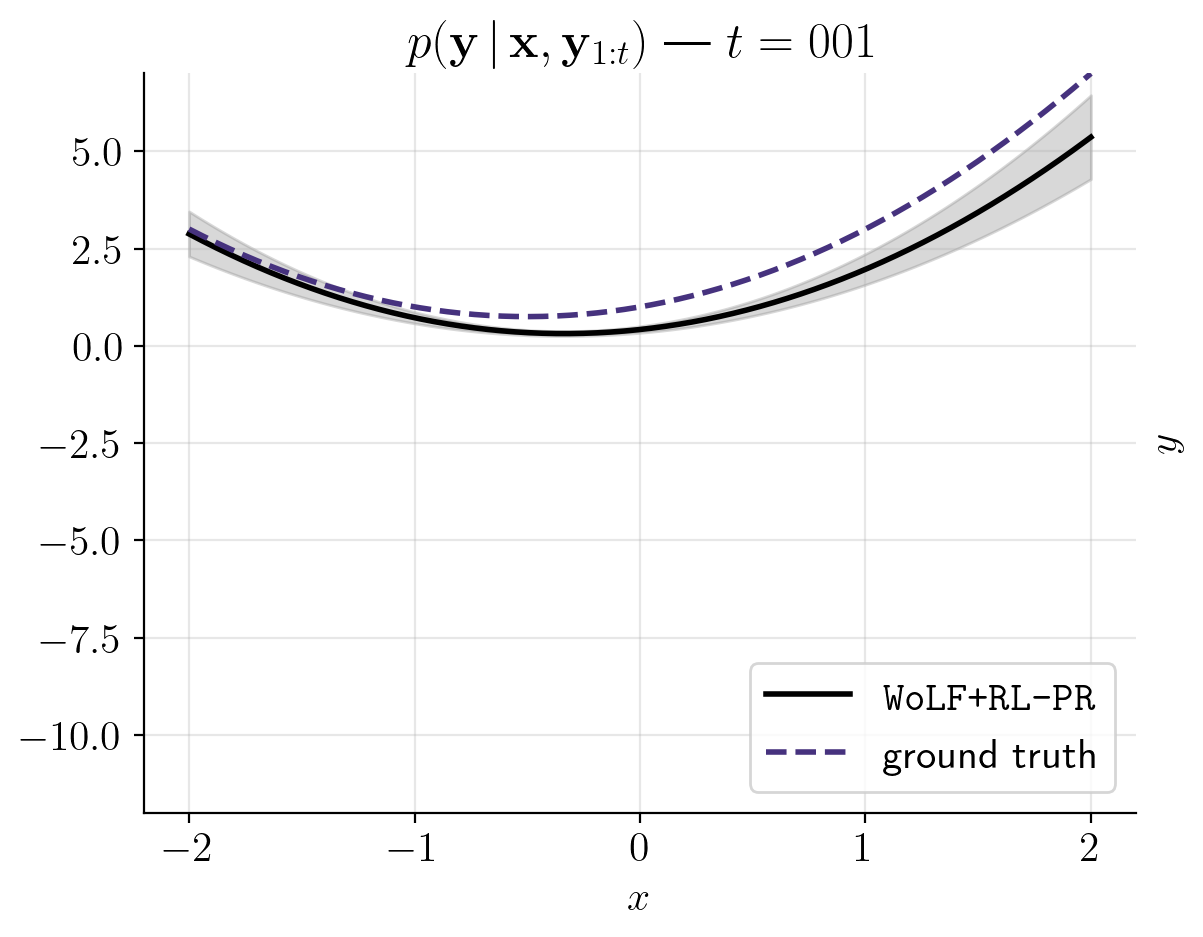

In [51]:
fig, ax = plt.subplots()

def get_ix(t, ell):
    # Number of steps to get to first observation at time t
    ix_step = t * (t + 1) // 2
    # Increase runlength
    ix = ix_step + ell
    return ix

xeval = Phi_test[:, 1]
def animate(t):
    ax.cla()
    print(t, end="\r")
    
    ix_init = get_ix(t, 0)
    ix_end = get_ix(t, t+1)

    params_true = hist["params"][t]
    ytrue = np.einsum("nm,m->n", Phi_test, params_true)

    awyhat = np.einsum("sm,km -> sk", Phi_test, wlbocd_out["bel"].mean[ix_init:ix_end])
    awyhat_mean = np.einsum("sk,k-> s", awyhat, wl_pr_change_ravel[ix_init:ix_end])
    awyhat_std = np.sqrt(
        jnp.einsum("sk,k-> s", awyhat ** 2, wl_pr_change_ravel[ix_init:ix_end]) - awyhat_mean ** 2
    )

    tmin = max(0, t - 150)
    alpha_vals = jnp.linspace(0, 1, len(y.squeeze()[tmin:t]))

    plt.plot(xeval, awyhat_mean, c="black", linewidth=2, label=r"\texttt{WoLF+RL-PR}")
    plt.fill_between(
        xeval, awyhat_mean - 2 * awyhat_std, awyhat_mean + 2 * awyhat_std, color="tab:gray", alpha=0.3
    )

    plt.plot(xeval, ytrue, c=colors[t], label="ground truth", linewidth=2, linestyle="--")
    
    plt.scatter(Xcpu[tmin:t, 1], ycpu[tmin:t], c=colors[tmin:t], alpha=alpha_vals)
    
    plt.grid(alpha=0.3)
    plt.ylim(-12, 7)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    ax.yaxis.set_label_position("right")
    plt.title(r"$p({\bf y}\,\vert\,{\bf x}, {\bf y}_{1:t})$"f" | $t={t:03}$")
    plt.grid(alpha=0.3)
    plt.legend(loc="lower right")

anim = FuncAnimation(fig, animate, np.arange(1, 300))
# anim.save("./figures/wbocd-bocd-tdist-lr-corrupted.gif", fps=10)
anim.save("./figures/wbocd-bocd-tdist-lr-corrupted-single.mp4", fps=10, dpi=200)

## Simulations

In [39]:
def step_specific(state, key, change_pos):
    params, count = state
    
    key_x, key_y, key_params = jax.random.split(key, 3)
    change = (count == change_pos)

    key_theta0, key_theta1, key_theta2 = jax.random.split(key_params, 3)
    params_change = jax.random.uniform(key_params, (3,), minval=-3, maxval=3)
    
    params = params * (1 - change) + params_change * change

    x = jax.random.uniform(key_x, minval=-2, maxval=2)
    x = jnp.c_[1, x, x ** 2]
    
    yclean = x @ params
    y = yclean + jax.random.t(key_y, df=2.01)
    # y = yclean + jax.random.normal(key_y)

    out = {
        "params": params,
        "y": y,
        "x": x,
        "yclean": yclean,
        "change": change,
    }

    return (params, count + 1), out

In [40]:
def apply_fn(w, x): return jnp.atleast_1d(w @ x)

def compute_rlpr_errs(out, filter, yclean):
    n_samples = len(yclean)
    rlpr_errs = np.zeros(n_samples)
    for t in tqdm(range(1, n_samples - 1), leave=False):
        ix_init = filter.get_ix(t, 0)
        ix_end = filter.get_ix(t, t+1)
        log_joint = out["log_runlength_posterior"][ix_init:ix_end]
        prob = jnp.exp(log_joint - jax.nn.logsumexp(log_joint))
        
        means = out["bel"].mean[ix_init:ix_end]
        yhat = ((means @ X[t+1]) * prob).sum()
        rlpr_errs[t] = yclean[t+1] - yhat

    return rlpr_errs

In [41]:
key = jax.random.PRNGKey(3)

In [42]:
n_samples = 300
keys = jax.random.split(key, n_samples)
theta_init = jnp.array([1.0, 1.0, 1.0])
d = len(theta_init)
wprior = jnp.zeros(d)

state_init = (theta_init, 0)
_, hist = jax.lax.scan(partial(step_specific, change_pos=150), state_init, keys)
hist = jax.tree.map(np.array, hist)

beta = 1.0
segment = hist["change"].cumsum()
n_segments = len(np.unique(segment))
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)


In [43]:
X = jnp.squeeze(hist["x"])
y = jnp.squeeze(hist["y"])
yclean = np.array(hist["yclean"]).squeeze()

In [46]:
gfilter= GaussianFilter(apply_fn, dynamics_covariance=0.0)
bel_init = gfilter.init_bel(theta_init)
_, hist = gfilter.scan(bel_init, y, X, get_predicted_mean)
lrstatic_errs = ((hist * X).sum(axis=1) - yclean)

In [47]:
bocd = LinearModelFMBOCD(p_change, beta)
bel_init = bocd.init_bel(wprior, 1.0, n_samples)
bocd_out = bocd.scan(y, X, bel_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:21<00:00, 13.65it/s]


In [48]:
c = 3
wlbocd = RobustLinearModelFMBOCD(p_change, beta, c)
bel_init = wlbocd.init_bel(wprior, 1.0, n_samples)
wlbocd_out = wlbocd.scan(y, X, bel_init)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.53it/s]


In [49]:
bocd_errs = compute_rlpr_errs(bocd_out, bocd, yclean)

In [50]:
wlbocd_errs = compute_rlpr_errs(wlbocd_out, wlbocd, yclean)

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))

errs = pd.DataFrame({
    r"\texttt{WoLF+RL-PR}": wlbocd_errs,
    r"\texttt{Gauss+RL-PR}": bocd_errs,
    r"\texttt{Gauss+C-Static}": lrstatic_errs
})


np.sqrt(np.power(errs, 2).rolling(10).mean()).plot(ax=ax, linewidth=2)
for s in segments_init:
    ax.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

plt.xlim(10, 300)
plt.xlabel("num. observations")
plt.ylabel("rolling(10) RMSE")
ax.grid(alpha=0.3)
plt.savefig("./figures/rl-pr-outliers-sample-run.png", dpi=300, bbox_inches="tight")

## Multiple simulations

In [52]:
from time import time

In [53]:
c = 3
wlbocd = RobustLinearModelFMBOCD(p_change, beta, c)
bocd = LinearModelFMBOCD(p_change, beta)

In [ ]:
n_simulations = 30
theta_init = jnp.array([1.0, 1.0, 1.0])

hist_segment = []

bocd_all = []
wlbocd_all = []
lrstatic_all = []

time_init = time()
for n in range(n_simulations):
    print(n, end="\r")
    key_t = jax.random.fold_in(key, n)
    keys = jax.random.split(key_t, n_samples)

    _, hist = jax.lax.scan(step, theta_init, keys)
    hist = jax.tree.map(np.array, hist)
    
    segment = hist["change"].cumsum()
    hist_segment.append(segment)

    X = jnp.squeeze(hist["x"])
    y = jnp.squeeze(hist["y"])
    yclean = np.array(hist["yclean"]).squeeze()

    bel_init = bocd.init_bel(wprior, 1.0, n_samples)
    bocd_out = bocd.scan(y, X, bel_init)
    bocd_errs = compute_rlpr_errs(bocd_out, bocd, yclean)

    bel_init = wlbocd.init_bel(wprior, 1.0, n_samples)
    wlbocd_out = wlbocd.scan(y, X, bel_init)
    wlbocd_errs = compute_rlpr_errs(wlbocd_out, wlbocd, yclean)

    bel_init = gfilter.init_bel(theta_init)
    _, hist = gfilter.scan(bel_init, y, X, get_predicted_mean)
    lrstatic_errs = ((hist * X).sum(axis=1) - yclean)

    bocd_all.append(bocd_errs)
    wlbocd_all.append(wlbocd_errs)
    lrstatic_all.append(lrstatic_errs)
total_time = time() - time_init

In [58]:
total_time / 60

22.97167315085729

In [59]:
bocd_all = pd.DataFrame(np.stack(bocd_all).T)
wlbocd_all = pd.DataFrame(np.stack(wlbocd_all).T)
lrstatic_all = pd.DataFrame(np.stack(lrstatic_all).T)
hist_segment = np.stack(hist_segment)

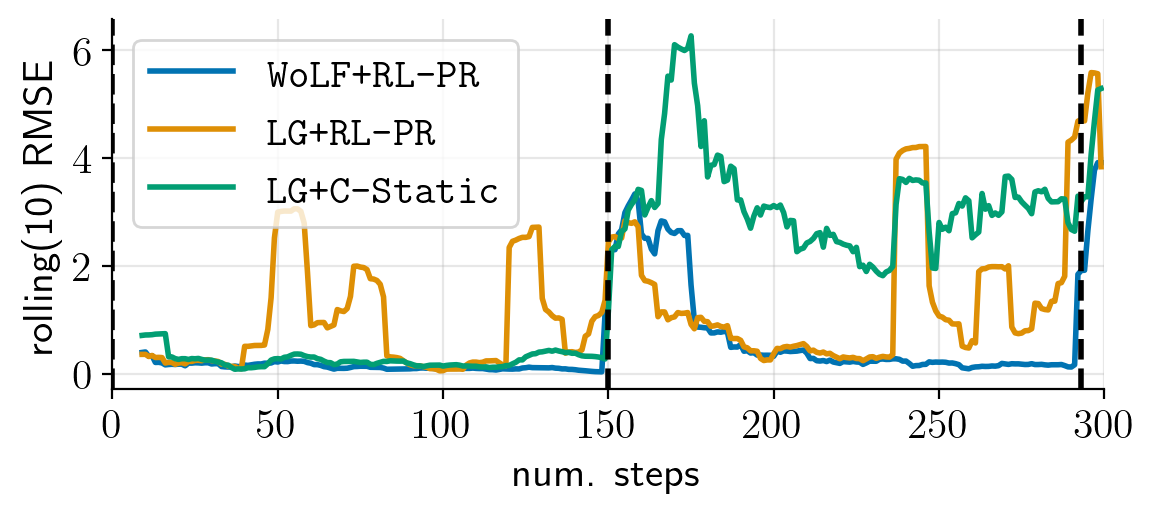

In [62]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))

ix = 3
# ix = 13
np.sqrt(np.power(wlbocd_all[ix], 2).rolling(10).mean()).plot(label=r"\texttt{WoLF+RL-PR}", linewidth=2)
np.sqrt(np.power(bocd_all[ix], 2).rolling(10).mean()).plot(label=r"\texttt{LG+RL-PR}", linewidth=2)
np.sqrt(np.power(lrstatic_all[ix], 2).rolling(10).mean()).plot(label=r"\texttt{LG+C-Static}", linewidth=2)

segment = hist_segment[ix]
n_segments = len(np.unique(segment))
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)

for s in segments_init:
    ax.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

plt.ylabel("rolling(10) RMSE")
plt.xlabel("num. steps")
plt.legend()
plt.xlim(0, 300)
plt.grid(alpha=0.3)
plt.savefig("../figures/rl-pr-outliers-sample-run.png", dpi=300, bbox_inches="tight")

In [63]:
rmse_bocd = np.sqrt(np.power(bocd_all, 2).mean(axis=0))
rmse_wlbocd = np.sqrt(np.power(wlbocd_all, 2).mean(axis=0))
rmse_static = np.sqrt(np.power(lrstatic_all, 2).mean(axis=0))

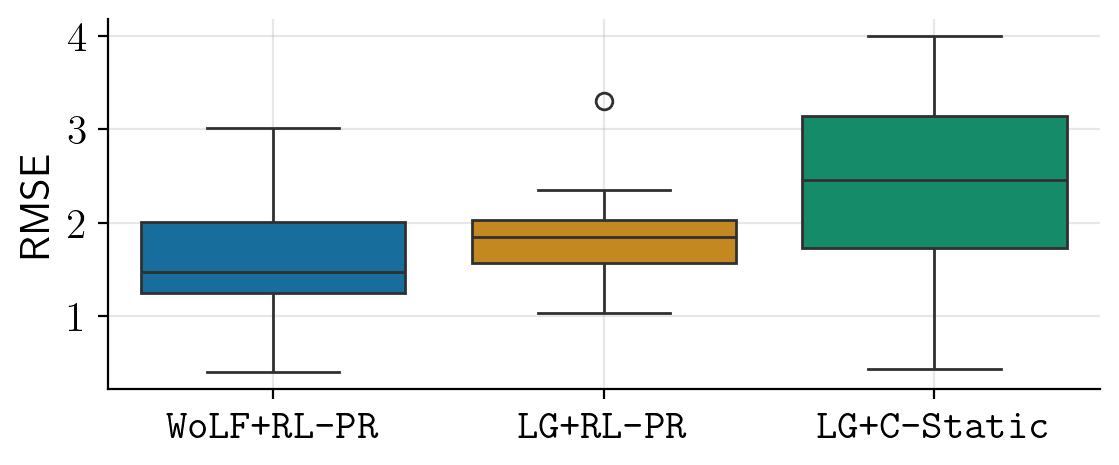

In [65]:
rmse = pd.DataFrame({
    r"\texttt{WoLF+RL-PR}": rmse_wlbocd,
    r"\texttt{LG+RL-PR}": rmse_bocd,
    r"\texttt{LG+C-Static}": rmse_static

})
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))
sns.boxplot(rmse)
plt.grid(alpha=0.3)
plt.ylabel("RMSE")
plt.xlabel("method")

# for ticklabel in plt.gca().get_xticklabels():
#     tickcolor = "teal" if "WoLF" in ticklabel.get_text() else "crimson"
#     ticklabel.set_color(tickcolor)
plt.xlabel("")

plt.savefig("../figures/rl-pr-outliers-res.png", dpi=300, bbox_inches="tight")

## Multiple $c$ values

In [97]:
%%time
c_values = np.linspace(1, 10, 20)
# c_values = np.linspace(20, 30, 2)
# c_values = [50, 100, 150]
errs_stress = {}
for c in c_values:
    print(c, end="\r")
    wlbocd = RobustLinearModelFMBOCD(p_change, beta, c)
    bel_init = wlbocd.init_bel(wprior, 1.0, n_samples)
    wlbocd_out = wlbocd.scan(y, X, bel_init)
    wlbocd_errs = compute_rlpr_errs(wlbocd_out, wlbocd, yclean)
    errs_stress[c] = wlbocd_errs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.12it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.16it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.18it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.14it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.35it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:23<00:00, 13.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.26it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.17it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.16it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:21<00:00, 14.19it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.38it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.09it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.42it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.21it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.25it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.45it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:23<00:00, 13.01it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.24it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.20it/s]
                                                                                                                                                          

CPU times: user 10min 31s, sys: 38.4 s, total: 11min 10s
Wall time: 7min 50s


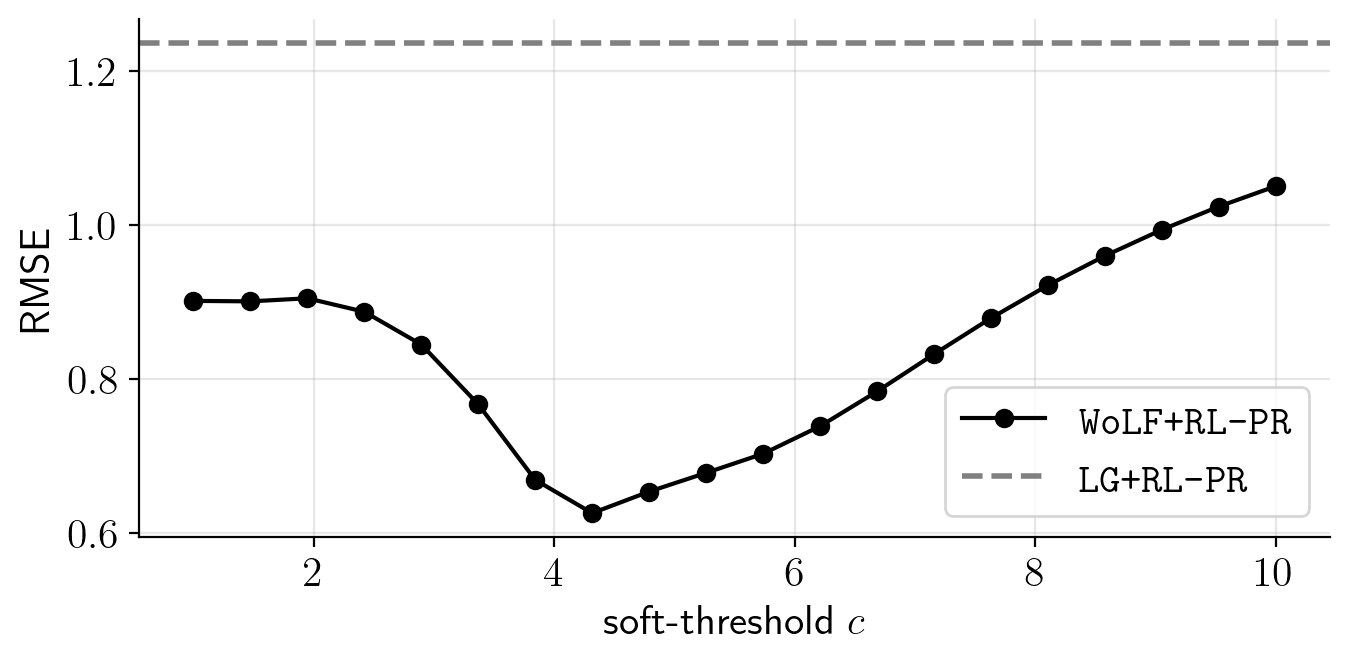

In [174]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.7))
plt.plot(
    # np.sqrt(pd.DataFrame(errs_stress).mean(axis=0))
    np.sqrt(np.power(pd.DataFrame(errs_stress), 2).mean(axis=0))
    ,
    marker="o", label=r"\texttt{WoLF+RL-PR}",
    c="black"
)
plt.axhline(
    np.sqrt(np.power(bocd_errs, 2).mean()),
    # np.power(pd.DataFrame(errs_stress), 2).mean(axis=0)
    c="gray", label=r"\texttt{LG+RL-PR}", linestyle="--", linewidth=2
)
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel("soft-threshold $c$")
plt.ylabel("RMSE")
plt.savefig("./figures/lr-wolf-rmse-varying-c.png", dpi=300, bbox_inches="tight")